In [ ]:
import time
import pickle
import numpy as np
import robotic as ry
from tqdm import tqdm
import matplotlib.pyplot as plt

from explore.env.MujocoSim import MjSim
from explore.datasets.AdjMap import AdjMap
from explore.datasets.rnd_configs import RndConfigs

In [2]:
tree_count = 100

with open("../data/trees.pkl", "rb") as f:
    trees: list[list[dict]] = pickle.load(f)

In [3]:
top_nodes = []
min_costs = []
for i in tqdm(range(tree_count)):

    tree_min_costs = [float("inf") for _ in range(tree_count)]
    tree_top_nodes = [-1 for _ in range(tree_count)]
    
    for n, node in enumerate(trees[i]):
        for j in range(tree_count):
            if node["costs"][j] < tree_min_costs[j]:
                tree_min_costs[j] = node["costs"][j]
                tree_top_nodes[j] = n
    
    top_nodes.append(tree_top_nodes)
    min_costs.append(tree_min_costs)

100%|██████████| 100/100 [00:00<00:00, 106.95it/s]


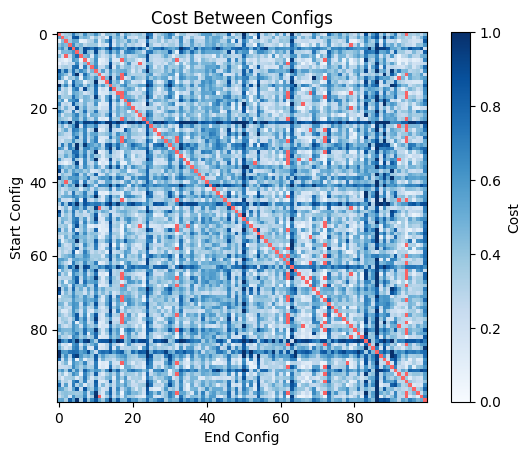

In [5]:
adj_map = AdjMap(configs_dir="..", notebook=True)
for i in range(tree_count):
    for j in range(tree_count):
        adj_map.set_value(i, j, min_costs[i][j])
adj_map.update_data()
adj_map.show()

In [ ]:
colors = [-1 for _ in range(tree_count)]

max_color_idx = 0
for i in range(tree_count):
        
    if colors[i] == -1:
        colors[i] = max_color_idx
        max_color_idx += 1
        
        for j in range(tree_count):
            if min_costs[i][j] <= 5e-2:
                if colors[j] != -1:
                    c = colors[j]
                    for k in range(tree_count):
                        if colors[k] == c:
                            colors[k] = colors[i]
                else:
                    colors[j] = colors[i]

groups = []
for c in colors:
    if not c in groups:
        groups.append(c)

group_sizes = [0 for _ in groups]
for c in colors:
    group_sizes[groups.index(c)] += 1

print(colors)
print(groups)
print("Group Count: ", len(groups))
print("Group Sizes: ", group_sizes)

In [ ]:
top_paths_data = []
for i in range(tree_count):
    for j in range(tree_count):
        if min_costs[i][j] < 5e-2:
            top_paths_data.append(
                ((i, j), top_nodes[i][j])
            )

top_paths = []
top_paths_start = []
top_paths_goal = []
for path_data in top_paths_data:

    start_idx = path_data[0][0]
    end_idx = path_data[0][1]
    if start_idx == end_idx: continue
    
    tree = trees[start_idx]
    
    node = tree[path_data[1]]
    path = []
    
    while True:
        path.append(node)
        if node["parent"] == -1: break
        node = tree[node["parent"]]
    
    path.reverse()
    assert path[0] == tree[0]

    top_paths.append(path)
    top_paths_start.append(start_idx)
    top_paths_goal.append(end_idx)

target_counts = []
for i, path in enumerate(top_paths):
    goal_idx = top_paths_goal[i]
    target_counts.append(0)
    for node in path:
        if goal_idx == node["target_config_idx"]:
            target_counts[-1] += 1

percs = [float(np.round(c/len(top_paths[i])*100)) for i, c in enumerate(target_counts)]
percs.sort()
percs.reverse()
print("Percetage of reached config used as target: ", percs)
print("Avg. use of reached config as target: ", sum(percs)/len(percs))
print("Found Trajectories Count: ", len(top_paths), " of ", tree_count**2)
print("When considering full graph: ", sum([v**2 for v in group_sizes]), " of ", tree_count**2)

In [ ]:
while True:
    path_idx = np.random.randint(0, len(top_paths))
    path = top_paths[path_idx]
    if len(path) != 1: break

start_idx = top_paths_start[path_idx]
end_idx = top_paths_goal[path_idx]
print("Start idx: ", start_idx)
print("End idx: ", end_idx)

path_lens = [len(p) for p in top_paths]
path_lens.sort()
path_lens.reverse()
print("Path lengths: ", path_lens)

D = RndConfigs("../configs/twoFingers.g", "../configs/rnd_twoFingers.h5")
C_start = ry.Config()
C_start.addConfigurationCopy(D.C)
C_end = ry.Config()
C_end.addConfigurationCopy(D.C)
C_play = ry.Config()
C_play.addConfigurationCopy(D.C)

C_start.getFrame("obj").setPosition(D.positions[start_idx,:3])
C_start.setJointState(D.positions[start_idx,3:])
C_play.getFrame("obj").setPosition(D.positions[start_idx,:3])
C_play.setJointState(D.positions[start_idx,3:])
C_end.getFrame("obj").setPosition(D.positions[end_idx,:3])
C_end.setJointState(D.positions[end_idx,3:])

print("Sampled Path Length: ", len(path))
C_start.view(False, "Start Config")
C_end.view(False, "End Config")
C_play.view(True, "Simulation Config")

sim = MjSim(open("../configs/twoFingers.xml", 'r').read(), C_play, view=False, verbose=0)

tau = .1
sim.setState(*path[0]["state"])
path.pop(0)
for node in path:
    q_target = node["action"]
    sim.resetSplineRef(node["time"])
    sim.setSplineRef(q_target.reshape(1,-1), [tau], append=False)
    for i in range(10):
        sim.step([], tau/10, ry.ControlMode.spline, view=tau/10)
        C_play.view(False, "Simulation Config")
        time.sleep(tau/10)

C_play.view(True, "Simulation Config")

In [ ]:
del C_start
del C_play
del C_end